In [23]:
import pandas as pd
import scipy as sp
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

%matplotlib inline

## Question 1
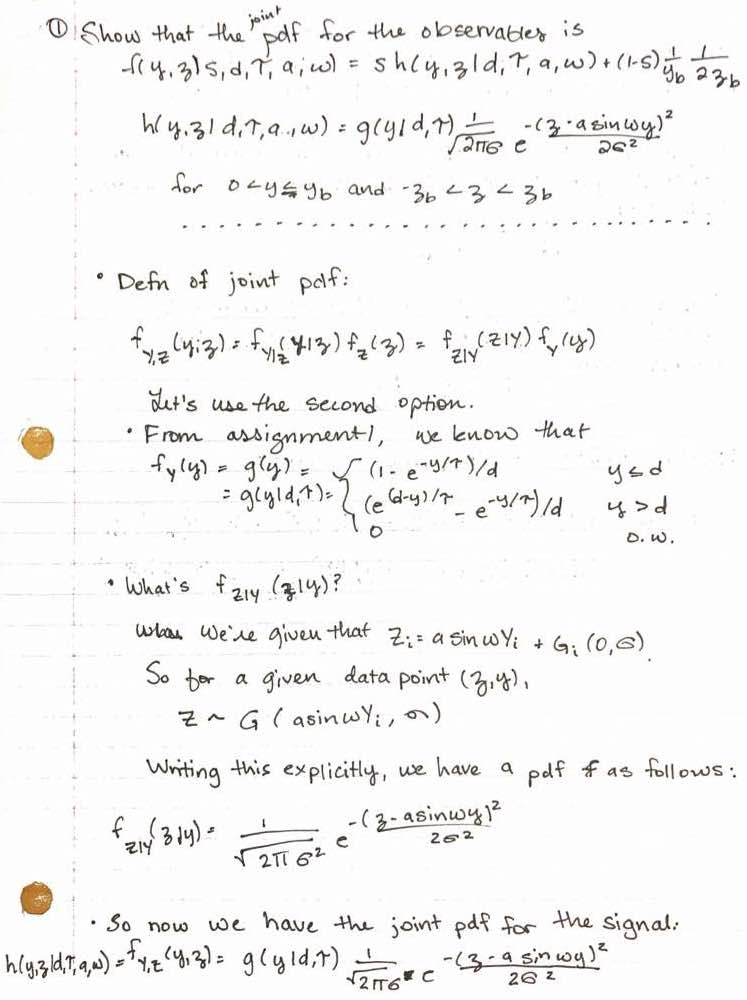
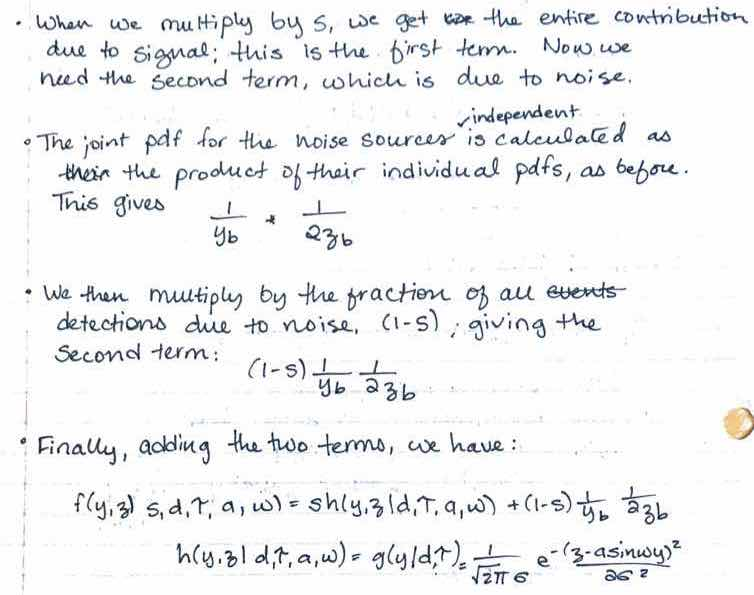

## Question 2
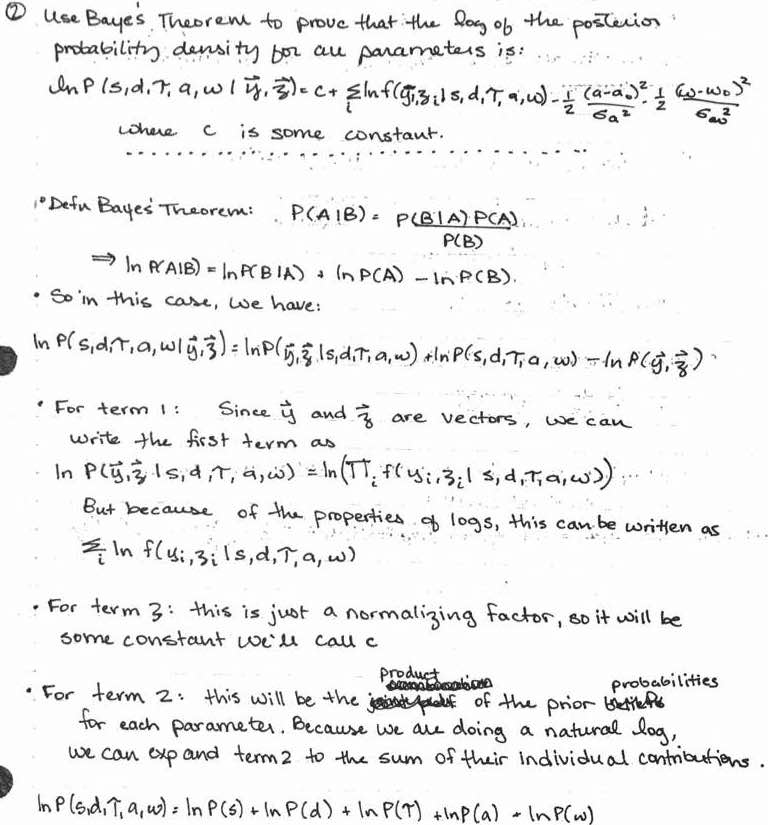
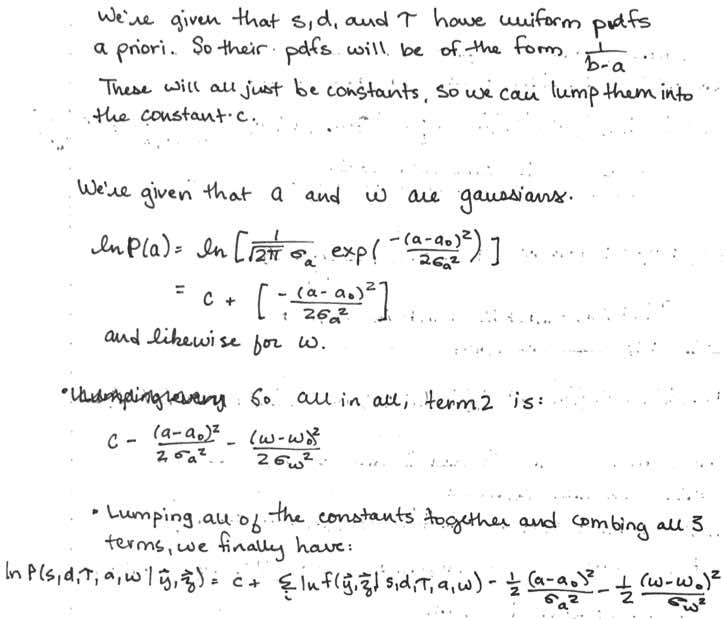

## Question 3
Write an mcmc algorithm.

In [2]:
# input parameters

# nominal values
s_nom = 0.75
d_nom = 4.
tau_nom = 1.
a_nom = 5.
w_nom = 1.

theta_nom = [s_nom, d_nom, tau_nom, a_nom, w_nom]

# hypercube step distances
ds = 0.05
dd = 0.4
dtau = 0.2
da = 0.1
sigmaa = 0.1
dw = 0.02
sigmaw = 0.2

# background noise
sigma_znoise = 2.
bkg_yb = 10.
bkg_zb = 10.

# markov chain length
test_chain_length = 50 # to start with, could increase later
chain_length = 10**4

# credible interval percentage
cred_percent = 90

In [3]:
# load the data
data = np.loadtxt('datafile.txt', delimiter=',')

In [4]:
# a function to pick a new location in the hypercube
def new_loc(theta_curr, ds, dd, dtau, da, sigmaa, dw, sigmaw):
    
    # drawn from the uniform distribution
    s_new = theta_curr[0] + np.random.uniform(-ds, ds)
    d_new = theta_curr[1] + np.random.uniform(-dd, dd)
    tau_new = theta_curr[2] + np.random.uniform(-dtau, dtau)
    a_new = theta_curr[3] + np.random.uniform(-da, da)
    w_new = theta_curr[4] + np.random.uniform(-dw, dw)   
    
    # lump these all together into a list
    theta_new = [s_new, d_new, tau_new, a_new, w_new]
    
    return(theta_new)

In [5]:
# evaluate g(y|d,tau)
# changed slightly from assignment 1 because tau is no longer fixed to a value of one
def g(data, theta):
    ys = data[:,0]
    d = theta[1]
    tau = theta[2]
    gs = []  # a list of g values 
    
    for y in ys:
        if y <= d:  # region one
            g = (1 - np.exp(-y / tau)) / d
        else:  # region two
            g = (np.exp((d - y) / tau)-np.exp(-y / tau)) / d
        gs.append(g)
        
    return(gs)

In [6]:
# evaluate h(y,z|d,tau,a,w)
def h(theta, g_out):
    z = data[:,1]
    y = data[:,0]
    
    h = (g_out / (np.sqrt(2*np.pi) * sigma_znoise)) * np.exp((-(z - theta[3] * np.sin(theta[4] * \
        y))**2) / (2 * sigma_znoise**2))
    return(h)

In [7]:
# evaluate f(y,z|s,d,tau,a,w)
def f(theta, h_out, bkg_yb, bkg_zb):
    f = theta[0] * h_out + (1-theta[0]) * (1/bkg_yb) * (1 / (2*bkg_zb))
    return(f)

In [8]:
# function to evaluate ln(P(theta))
def lnP(theta, theta_nom,
        lnf, h, g,
        sigmaa, sigmaw, sigma_znoise, 
        data, 
        bkg_yb, bkg_zb):
    
    g_out = g(data, theta)
    h_out = h(theta, g_out) 
    lnf = np.log(f(theta, h_out, bkg_yb, bkg_zb))
    
    # ignore the constant c
    lnP = np.sum(lnf) - 0.5 * ((theta[3] - theta_nom[3])**2) / (sigmaa**2) - (0.5) * \
          ((theta[4] - theta_nom[4])**2) / (sigmaw**2)
    return(lnP)

In [9]:
# test if the current value should be repeated or updated to the new one
def test_accept(theta_curr, theta_new, theta_nom, 
                f, h, g,
                sigmaa, sigmaw, sigma_znoise,
                data,
                bkg_yb, bkg_zb):
    # accept is a boolean, True if we should update the current value to the new one
    
    lnP_curr = lnP(theta_curr, theta_nom, f, h, g, sigmaa, sigmaw, sigma_znoise, data, bkg_yb, bkg_zb)
    lnP_new = lnP(theta_new, theta_nom, f, h, g, sigmaa, sigmaw, sigma_znoise, data, bkg_yb, bkg_zb)
    
    ratio = np.exp(lnP_new - lnP_curr)
    
    # metropolis-hasting: pick a random number (uniform[0,1]) to compare the likelihood ratio with
    u = np.random.uniform(high=1, low=0)
    
    if ratio > u:
        accept = True
    else:
        accept = False

    return(accept)

In [10]:
# the actual loop to make the chain
def mcmc(chain_length, theta_nom,
         ds, dd, dtau, da, sigmaa, dw, sigmaw,
         verbose=False, burnin=0):
    
    theta_curr = theta_nom  # start with the nominal parameter values
    chain = [theta_nom]     # the actual markov chain
    count_accept = 0        # for keeping track of the fraction of steps which are accepted
    
    # we're assuming no burn in is necessary in this case, but I want to include it for robustness
    if burnin > 0:
        chain_length += burnin
    
    for i in range(chain_length):
        # pick a new location
        theta_new = new_loc(theta_curr, ds, dd, dtau, da, sigmaa, dw, sigmaw)

        # test if it should be accepted
        accept = test_accept(theta_curr, theta_new, theta_nom, 
                             f, h, g, 
                             sigmaa, sigmaw, sigma_znoise,
                             data,
                             bkg_yb, bkg_zb)

        if accept:  # add new theta to chain and update
            chain.append(theta_new)
            theta_curr = theta_new
            count_accept += 1
        else:  # repeat old theta, don't update
            chain.append(theta_curr)
            
    if burnin > 0:  # slice off the burn in values 
        chain = chain[:burnin]
    
    if verbose:
        print('{}% of steps accepted'.format(count_accept/chain_length * 100))
            
    return(chain)  # it'll be a list of lists

In [11]:
# run the code- test for a short chain first to make sure it runs
test_chain = mcmc(test_chain_length, theta_nom,
                  ds, dd, dtau, da, sigmaa, dw, sigmaw,
                  verbose=True)

56.00000000000001% of steps accepted


Okay, great, it works. Now I can go on to make a really long chain.

## Question 4
* Run the mcmc code with chainlength = 10^4.

In [12]:
chain = mcmc(chain_length, theta_nom,
             ds, dd, dtau, da, sigmaa, dw, sigmaw,
             verbose=True)

/Users/brittanyhoward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/brittanyhoward/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


56.37% of steps accepted


Not really sure what the warning is about, so I am going to ignore it...

* Make plots showing the relationships between all parameters. Report parameter medians and 90% credible intervals.

In [27]:
chain = np.asarray(chain)  # np arrays are easier to slice up than lists of lists

s = chain[:,0]
d = chain[:,1]
tau = chain[:,2]
a = chain[:,3]
w = chain[:,4]

# report the median values of all parameters
print('---parameter medians---')
print('s: {}'.format(np.median(s)))
print('d: {}'.format(np.median(d)))
print('tau: {}'.format(np.median(tau)))
print('a: {}'.format(np.median(a)))
print('w: {}'.format(np.median(w)))

# report the credible intervals 
lower = (100 - cred_percent) / 2
upper = 100 - lower

print('\n---{}% credible intervals---'.format(cred_percent))
print('s: [{}, {}]'.format(round(np.percentile(s, lower),6), round(np.percentile(s, upper),6)))
print('d: [{}, {}]'.format(round(np.percentile(d, lower),6), round(np.percentile(d, upper),6)))
print('tau: [{}, {}]'.format(round(np.percentile(tau, lower),6), round(np.percentile(tau, upper),6)))
print('a: [{}, {}]'.format(round(np.percentile(a, lower),6), round(np.percentile(a, upper),6)))
print('w: [{}, {}]'.format(round(np.percentile(w, lower),6), round(np.percentile(w, upper),6)))

# just for fun, let's see how far we are from nominal values
print('\n---offset from nominal values---')
print('s:   nominal value: {}  offset: {}%'.format(theta_nom[0], round(((theta_nom[0]-np.median(s))/theta_nom[0])*100),5))
print('d:   nominal value: {}   offset: {}%'.format(theta_nom[1], round(((theta_nom[1]-np.median(d))/theta_nom[1])*100),5))
print('tau: nominal value: {}   offset: {}%'.format(theta_nom[2], round(((theta_nom[2]-np.median(tau))/theta_nom[2])*100),5))
print('a:   nominal value: {}   offset: {}%'.format(theta_nom[3], round(((theta_nom[3]-np.median(a))/theta_nom[3])*100),5))
print('w:   nominal value: {}   offset: {}%'.format(theta_nom[4], round(((theta_nom[4]-np.median(w))/theta_nom[4])*100),5))


---parameter medians---
s: 0.7403558686343711
d: 4.108919536780534
tau: 1.0129333566953738
a: 4.999089617731769
w: 0.9696893094121626

---90% credible intervals---
s: [0.624786, 0.842811]
d: [3.28713, 5.316712]
tau: [0.369274, 1.670391]
a: [4.839394, 5.158986]
w: [0.925587, 1.012111]

---offset from nominal values---
s:   nominal value: 0.75  offset: 1.0%
d:   nominal value: 4.0   offset: -3.0%
tau: nominal value: 1.0   offset: -1.0%
a:   nominal value: 5.0   offset: 0.0%
w:   nominal value: 1.0   offset: 3.0%


So the nominal values seem to have been really close to the true ones. Later I will see what happens if I change the nominal values to be further away.

In [21]:
# so that the plot doesn't get buried in a scrolling output cell
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f002cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121e00da0>]], dtype=object)

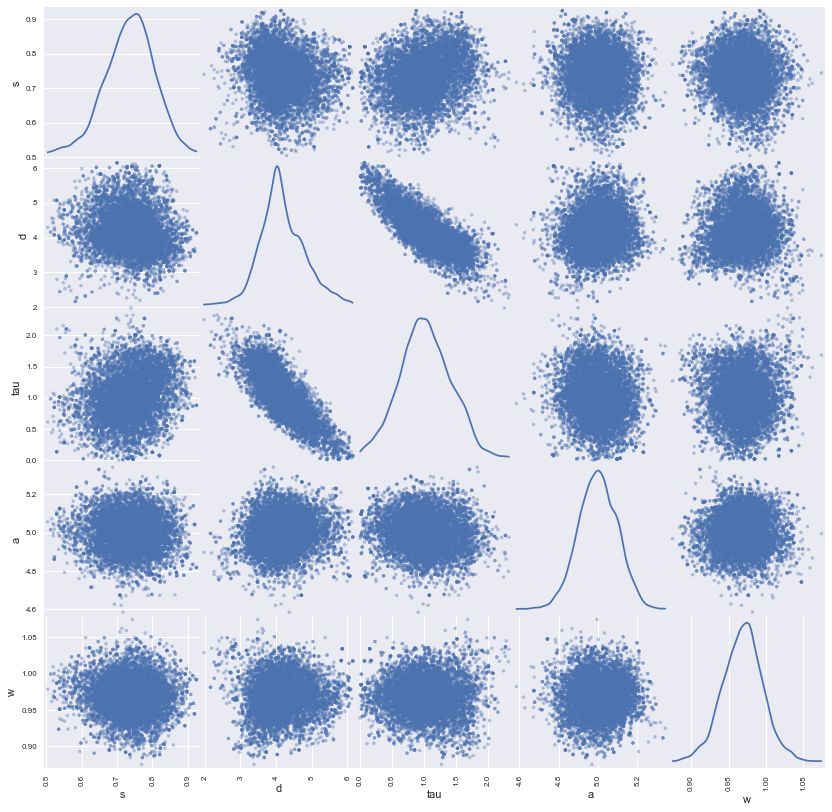

In [22]:
# make the plots 
df = pd.DataFrame(data=chain, columns=['s','d','tau','a','w'])
scatter_matrix(df, alpha=0.4, figsize=(14, 14), diagonal='kde')

* Comment on any pairs showing strong correlation:


There is noticable negative correlation between $\tau$ and $d$. Here are some numbers to make it more concrete.

In [15]:
df.corr()

,s,d,tau,a,w
s,1.000000,-0.143145,0.228380,-0.061268,-0.060304
d,-0.143145,1.000000,-0.799184,0.094887,0.039027
tau,0.228380,-0.799184,1.000000,-0.109268,-0.022853
a,-0.061268,0.094887,-0.109268,1.000000,0.027493
w,-0.060304,0.039027,-0.022853,0.027493,1.000000
